In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd

# Define the model name and paths
model_name = 'ProsusAI/finbert'
trained_model_path = 'finbert_optimizer_Adam_lr_2e-05_epochs_3_bs_6_maxlen_512'  # Replace with the actual path to your saved model

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(trained_model_path)
model = AutoModelForSequenceClassification.from_pretrained(trained_model_path)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)  # Apply softmax to get probab ilities

    # Get predicted class
    predicted_class = torch.argmax(predictions).item()

    return predicted_class

# Example usage
text1 = "I am very happy about the price increase in Bitcoin today."
text2 = "Bitcoin price plunges unexpectedly."

sentiment1 = predict_sentiment(text1)
sentiment2 = predict_sentiment(text2)

print(f"Sentiment for text1: {sentiment1}")
print(f"Sentiment for text2: {sentiment2}")

Sentiment for text1: 0
Sentiment for text2: 1


In [15]:
import requests

response = requests.get("https://api.coingecko.com/api/v3/coins/bitcoin/market_chart", 
                        params={"vs_currency": "usd", "days": "365", "interval": "daily"})
data = response.json()

In [18]:
data

{'prices': [[1731628800000, 87407.51273710128],
  [1731715200000, 90947.97509443703],
  [1731801600000, 90606.45489380708],
  [1731888000000, 89841.47194135105],
  [1731974400000, 90534.62459650292],
  [1732060800000, 92251.65240738312],
  [1732147200000, 94217.02229634205],
  [1732233600000, 98509.11859102432],
  [1732320000000, 98927.49494553401],
  [1732406400000, 97679.46381643033],
  [1732492800000, 98015.9355289458],
  [1732579200000, 93004.70093103287],
  [1732665600000, 91931.83077291827],
  [1732752000000, 95981.18057210564],
  [1732838400000, 95661.59595817851],
  [1732924800000, 97453.2473451042],
  [1733011200000, 96513.14234698225],
  [1733097600000, 97311.70719084324],
  [1733184000000, 95833.1362300365],
  [1733270400000, 96031.63097759831],
  [1733356800000, 98881.4694561823],
  [1733443200000, 97201.50036407741],
  [1733529600000, 99973.85150659826],
  [1733616000000, 99781.82999198174],
  [1733702400000, 101235.3717025316],
  [1733788800000, 97353.94700820887],
  [173

In [27]:
import requests
import pandas as pd
import os

os.makedirs("crypto_data", exist_ok=True)

def download_binance(symbol):
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": symbol,
        "interval": "1d",
        "limit": 1000      # you can increase this later with pagination
    }

    resp = requests.get(url, params=params)
    data = resp.json()

    df = pd.DataFrame(data, columns=[
        "open_time","open","high","low","close","volume",
        "close_time","quote_asset_volume","number_of_trades",
        "taker_buy_base","taker_buy_quote","ignore"
    ])

    df["timestamp"] = pd.to_datetime(df["open_time"], unit="ms")
    df["price"] = df["close"].astype(float)
    df = df[["timestamp", "price"]]

    out_name = f"crypto_data/{symbol}.csv"
    df.to_csv(out_name, index=False)

    print(f"Saved {out_name} with {len(df)} rows")
    return df


In [31]:
download_binance("ETHUSDT")


Saved crypto_data/ETHUSDT.csv with 1000 rows


,timestamp,price
0,2023-02-19,1679.75
1,2023-02-20,1703.27
2,2023-02-21,1659.76
3,2023-02-22,1643.14
4,2023-02-23,1650.53
...,...,...
995,2025-11-10,3567.85
996,2025-11-11,3417.76
997,2025-11-12,3414.92
998,2025-11-13,3231.54


In [32]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

DATA_DIR = "crypto_data"       
SEQ_LEN = 365                  
HORIZON = 7                   

# ---------------------------------------------------------
# Load CSV and extract close prices
# ---------------------------------------------------------
def load_csv_prices(path):
    df = pd.read_csv(path)
    if "timestamp" in df.columns:
        df = df.sort_values("timestamp")
    return df["price"].astype(float).values


# ---------------------------------------------------------
# Build dataset of log-return windows
# ---------------------------------------------------------
def build_dataset():
    X, Y = [], []

    for fname in os.listdir(DATA_DIR):
        if not fname.endswith(".csv"):
            continue

        path = os.path.join(DATA_DIR, fname)
        print("Loading:", fname)
        prices = load_csv_prices(path)

        # Convert to log returns
        logp = np.log(prices)
        lrets = np.diff(logp)

        # Sliding windows
        for i in range(len(lrets) - SEQ_LEN - HORIZON):
            x = lrets[i:i+SEQ_LEN]
            y = lrets[i+SEQ_LEN:i+SEQ_LEN+HORIZON]

            X.append(x.reshape(SEQ_LEN, 1))
            Y.append(y)

    X = np.array(X)
    Y = np.array(Y)
    print("Dataset shapes:", X.shape, Y.shape)
    return X, Y


# ---------------------------------------------------------
# Build LSTM Model
# ---------------------------------------------------------
def build_model():
    model = Sequential([
        LSTM(128, input_shape=(SEQ_LEN,1)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(HORIZON)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


# ---------------------------------------------------------
# TRAINING
# ---------------------------------------------------------
X, Y = build_dataset()

model = build_model()
model.summary()

history = model.fit(
    X, Y,
    validation_split=0.1,
    epochs=40,
    batch_size=64,
    verbose=2
)


# ---------------------------------------------------------
# SAVE MODELS
# ---------------------------------------------------------
os.makedirs("model", exist_ok=True)

# Save Keras model (.h5)
model.save("model/price_predictor.h5")
print("Saved: model/price_predictor.h5")


# Joblib wrapper so main.py can load it naturally
class PredictorWrapper:
    def __init__(self, h5_path):
        self.h5_path = h5_path
        self.model = None

    def _load(self):
        if self.model is None:
            self.model = tf.keras.models.load_model(self.h5_path)

    def predict(self, X, verbose=0):
        self._load()
        return self.model.predict(X, verbose=verbose)


joblib.dump(PredictorWrapper("model/price_predictor.h5"),
            "model/price_predictor.pkl")
print("Saved: model/price_predictor.pkl")


# Dummy scaler for compatibility
joblib.dump({"type": "dummy_scaler_not_used"},
            "model/scaler.pkl")
print("Saved: model/scaler.pkl")

print("\nTraining Complete! 🚀")


Loading: BTCUSDT.csv
Loading: DOGEUSDT.csv
Loading: ETHUSDT.csv
Loading: SOLUSDT.csv
Dataset shapes: (2508, 365, 1) (2508, 7)


c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,783 (296.03 KB)

 Trainable params: 75,527 (295.03 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/40
36/36 - 10s - 290ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 2/40
36/36 - 8s - 219ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/40
36/36 - 8s - 211ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/40
36/36 - 8s - 223ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/40
36/36 - 8s - 216ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/40
36/36 - 8s - 208ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/40
36/36 - 9s - 237ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/40
36/36 - 8s - 235ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/40
36/36 - 9s - 261ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/40
36/36 - 9s - 251ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 11/40
36/36 - 8s - 230ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 12/40
36/36 - 11s - 302ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 13/40
36/36 - 19s - 524ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 14/40
36/36 - 9s - 241ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 15/40
36/36 - 10s - 

Saved: model/price_predictor.h5
Saved: model/price_predictor.pkl
Saved: model/scaler.pkl

Training Complete! 🚀


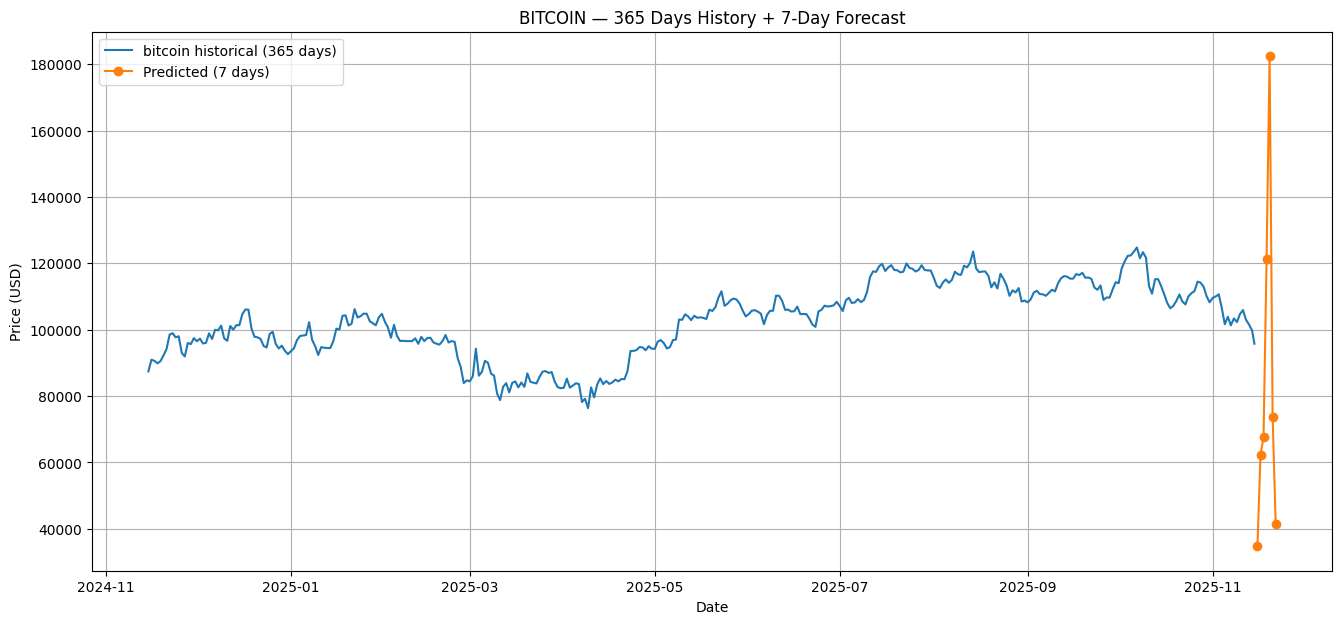


Predicted next 7 days:

2025-11-15 → $34,739.62
2025-11-16 → $62,222.22
2025-11-17 → $67,591.73
2025-11-18 → $121,424.88
2025-11-19 → $182,408.84
2025-11-20 → $73,665.69
2025-11-21 → $41,574.28


In [39]:
import requests
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta

# ============================================================
# LOAD MODEL SAFELY (compile=False avoids the MSE error)
# ============================================================

class PredictorWrapper:
    def __init__(self, h5_path):
        self.h5_path = h5_path
        self.model = None

    def _load(self):
        if self.model is None:
            # IMPORTANT FIX
            self.model = tf.keras.models.load_model(self.h5_path, compile=False)

    def predict(self, X, verbose=0):
        self._load()
        return self.model.predict(X, verbose=verbose)

# load your saved predictor.pkl
predictor = joblib.load("model/price_predictor.pkl")


# ============================================================
# USER SETTINGS
# ============================================================
coin = "bitcoin"   # change to ethereum, solana, dogecoin, etc.


# ============================================================
# FETCH LAST 365 DAYS OF PRICES
# ============================================================
url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
params = {"vs_currency": "usd", "days": "365", "interval": "daily"}

resp = requests.get(url, params=params)
data = resp.json()

prices = [p[1] for p in data["prices"]]
timestamps = [p[0] for p in data["prices"]]
dates = pd.to_datetime(timestamps, unit="ms")


# ============================================================
# PREPARE INPUT FOR MODEL (LOG RETURNS)
# ============================================================
logp = np.log(np.array(prices))
lrets = np.diff(logp)

# last 365 log-returns → shape (1, 365, 1)
X_input = lrets[-365:].reshape(1, 365, 1).astype(np.float32)


# ============================================================
# PREDICT NEXT 7 LOG-RETURNS
# ============================================================
pred_lrets = predictor.predict(X_input, verbose=0)[0]


# ============================================================
# RECONSTRUCT FUTURE PRICES
# ============================================================
future_prices = []
p = prices[-1]

for lr in pred_lrets:
    p = p * np.exp(lr)
    future_prices.append(float(p))

future_dates = [dates[-1] + timedelta(days=i) for i in range(1, 8)]


# ============================================================
# PLOT 365 + 7 DAY CHART
# ============================================================
plt.figure(figsize=(16, 7))
plt.plot(dates, prices, label=f"{coin} historical (365 days)")
plt.plot(future_dates, future_prices, marker="o", label="Predicted (7 days)")
plt.title(f"{coin.upper()} — 365 Days History + 7-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()


# ============================================================
# PRINT NEXT 7 DAYS
# ============================================================
print("\nPredicted next 7 days:\n")
for d, p in zip(future_dates, future_prices):
    print(f"{d.date()} → ${p:,.2f}")


In [43]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import joblib

DATA_DIR = "crypto_data"      # contains BTCUSDT.csv, ETHUSDT.csv, etc.
SEQ_LEN = 365
HORIZON = 7

# ------------------------------------------------------
# Load price column from CSV
# ------------------------------------------------------
def load_csv(path):
    df = pd.read_csv(path)
    return df["price"].astype(float).values

# ------------------------------------------------------
# Build dataset with per-coin standardization
# ------------------------------------------------------
X, Y = [], []
coin_stats = {}   # store mean/std for each coin

for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue

    path = os.path.join(DATA_DIR, fname)
    coin_name = fname.replace(".csv", "")
    prices = load_csv(path)

    logp = np.log(prices)
    lrets = np.diff(logp)  # raw log-returns

    # Normalize per coin
    mean = lrets.mean()
    std = lrets.std() + 1e-8
    norm_lrets = (lrets - mean) / std

    coin_stats[coin_name] = {"mean": mean, "std": std}
    print(f"{coin_name}: mean={mean:.6f}, std={std:.6f}")

    # sliding windows
    for i in range(len(norm_lrets) - SEQ_LEN - HORIZON):
        X.append(norm_lrets[i:i+SEQ_LEN].reshape(SEQ_LEN, 1))
        Y.append(norm_lrets[i+SEQ_LEN:i+SEQ_LEN+HORIZON])

X = np.array(X)
Y = np.array(Y)
print("Dataset:", X.shape, Y.shape)


# ------------------------------------------------------
# Build model
# ------------------------------------------------------
def build_model():
    model = Sequential([
        LSTM(128, input_shape=(SEQ_LEN,1)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(HORIZON)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


model = build_model()
model.summary()

history = model.fit(
    X, Y,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    verbose=2
)

# ------------------------------------------------------
# Save model + wrapper + stats
# ------------------------------------------------------
os.makedirs("models", exist_ok=True)

model.save("model/price_predictor.h5")
print("Saved model.h5")

joblib.dump(coin_stats, "model/coin_stats.pkl")
print("Saved per-coin stats")

# Save wrapper
class PredictorWrapper:
    def __init__(self, h5_path):
        self.h5_path = h5_path
        self.model = None

    def _load(self):
        if self.model is None:
            self.model = tf.keras.models.load_model(self.h5_path, compile=False)

    def predict(self, X, verbose=0):
        self._load()
        return self.model.predict(X, verbose=verbose)

joblib.dump(PredictorWrapper("model/price_predictor.h5"),
            "model/price_predictor.pkl")

print("Training done.")


BTCUSDT: mean=0.001380, std=0.024233
DOGEUSDT: mean=0.000629, std=0.046414
ETHUSDT: mean=0.000648, std=0.033149
SOLUSDT: mean=0.001745, std=0.044912
Dataset: (2508, 365, 1) (2508, 7)


c:\Users\siddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,783 (296.03 KB)

 Trainable params: 75,527 (295.03 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
36/36 - 14s - 376ms/step - loss: 1.3259 - val_loss: 0.9022
Epoch 2/20
36/36 - 14s - 376ms/step - loss: 1.3259 - val_loss: 0.9022
Epoch 2/20
36/36 - 18s - 494ms/step - loss: 1.2473 - val_loss: 0.9022
Epoch 3/20
36/36 - 18s - 494ms/step - loss: 1.2473 - val_loss: 0.9022
Epoch 3/20
36/36 - 19s - 528ms/step - loss: 1.2321 - val_loss: 0.9018
Epoch 4/20
36/36 - 19s - 528ms/step - loss: 1.2321 - val_loss: 0.9018
Epoch 4/20
36/36 - 17s - 480ms/step - loss: 1.2260 - val_loss: 0.9014
Epoch 5/20
36/36 - 17s - 480ms/step - loss: 1.2260 - val_loss: 0.9014
Epoch 5/20
36/36 - 11s - 319ms/step - loss: 1.2182 - val_loss: 0.9023
Epoch 6/20
36/36 - 11s - 319ms/step - loss: 1.2182 - val_loss: 0.9023
Epoch 6/20
36/36 - 16s - 437ms/step - loss: 1.2141 - val_loss: 0.9021
Epoch 7/20
36/36 - 16s - 437ms/step - loss: 1.2141 - val_loss: 0.9021
Epoch 7/20
36/36 - 10s - 279ms/step - loss: 1.2057 - val_loss: 0.9030
Epoch 8/20
36/36 - 10s - 279ms/step - loss: 1.2057 - val_loss: 0.9030
Epoch 8/20
36/36 - 1

Saved model.h5
Saved per-coin stats
Training done.


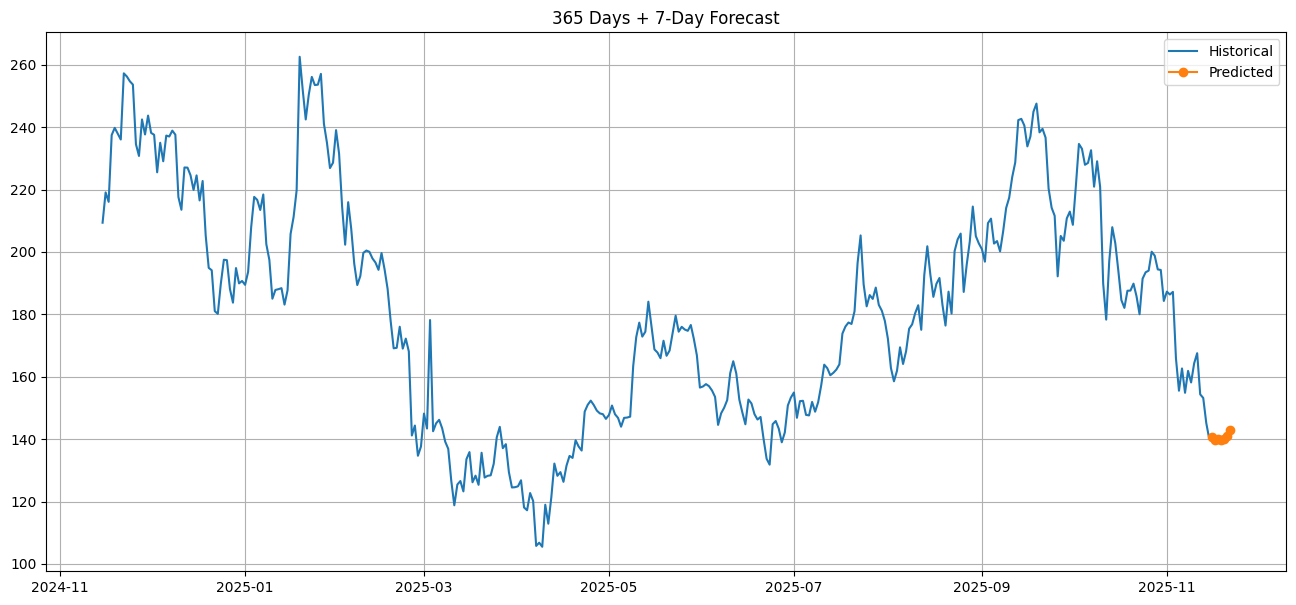

2025-11-15 → $ 140.75
2025-11-16 → $ 139.79
2025-11-17 → $ 140.08
2025-11-18 → $ 139.58
2025-11-19 → $ 140.13
2025-11-20 → $ 141.02
2025-11-21 → $ 142.96


In [48]:
import requests
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta

# Load predictor & stats
predictor = joblib.load("model/price_predictor.pkl")
coin_stats = joblib.load("model/coin_stats.pkl")  # per-coin training stats NOT used in inference

# -------------------------------------------
# SETTINGS
# -------------------------------------------
coin = "solana"   # btc, eth, sol, doge, etc.

# Fetch last 365 days
url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
params = {"vs_currency": "usd", "days": "365", "interval": "daily"}
resp = requests.get(url, params=params)
data = resp.json()

prices = np.array([p[1] for p in data["prices"]])
timestamps = [p[0] for p in data["prices"]]
dates = pd.to_datetime(timestamps, unit="ms")

# Compute log returns
logp = np.log(prices)
lrets = np.diff(logp)

# -------------------------------------------
# Normalize returns (per coin)
# -------------------------------------------
mean = lrets.mean()
std = lrets.std() + 1e-8
norm_lrets = (lrets - mean) / std

X_input = norm_lrets[-365:].reshape(1, 365, 1).astype(np.float32)

# Predict normalized future log-returns
pred_norm = predictor.predict(X_input, verbose=0)[0]

# De-normalize
pred_lrets = pred_norm * std + mean

# -------------------------------------------
# Reconstruct prices
# -------------------------------------------
last_price = prices[-1]
future_prices = []
p = last_price

for lr in pred_lrets:
    p = p * np.exp(lr)
    future_prices.append(float(p))

future_dates = [dates[-1] + timedelta(days=i) for i in range(1, 8)]

# -------------------------------------------
# Plot 365 + 7
# -------------------------------------------
plt.figure(figsize=(16,7))
plt.plot(dates, prices, label="Historical")
plt.plot(future_dates, future_prices, marker="o", label="Predicted")
plt.legend()
plt.grid(True)
plt.title("365 Days + 7-Day Forecast")
plt.show()

# Print predictions
for d, p in zip(future_dates, future_prices):
    print(d.date(), "→ $", round(p,2))
